# Dependencies

In [181]:
import os
import kagglehub

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
# from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
# from imblearn.ensemble import BalancedBaggingClassifier

import tensorflow as tf
from tensorflow import keras

# Data

In [5]:
path = kagglehub.dataset_download("barelydedicated/bank-customer-churn-modeling")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/bank-customer-churn-modeling


In [7]:
df = pd.read_csv(os.path.join(path, os.listdir(path)[0]))
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Main question:** Can you predict if bank customers will turnover next cycle?

## EDA
Conducting a simple EDA for data understanding.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [15]:
num_uc = df['CustomerId'].nunique()
num_d = df.duplicated().sum()

print(f"Number of unique customers: {num_uc}")
print(f"Number of duplicates in data: {num_d}")

Number of unique customers: 10000
Number of duplicates in data: 0


In [16]:
df = df.drop(columns=["RowNumber",	"CustomerId",	"Surname"])

In [17]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


No extreme outliers are present in the data, except in the target column ("Exited" column), where some class imbalance is immediately apparent.

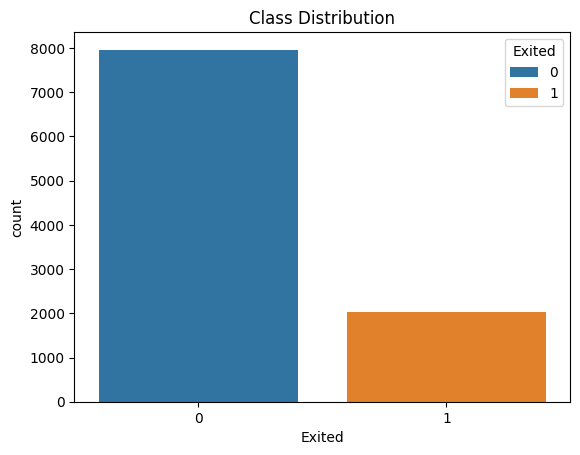

In [20]:
sns.countplot(data=df, x='Exited', hue='Exited')
plt.title('Class Distribution')
plt.show()

In [26]:
# Ratio
df['Exited'].value_counts()[0] / df['Exited'].value_counts()[1]

np.float64(3.9091801669121256)

In [27]:
def print_unique_col_values(df):
  for column in df:
    if df[column].dtypes == 'object':
      print(f'{column}: {df[column].unique()}')

print_unique_col_values(df)

Geography: ['France' 'Spain' 'Germany']
Gender: ['Female' 'Male']


In [35]:
# making one hot encoding categorical values
df = pd.get_dummies(data=df, columns=['Geography', 'Gender'], dtype=int)

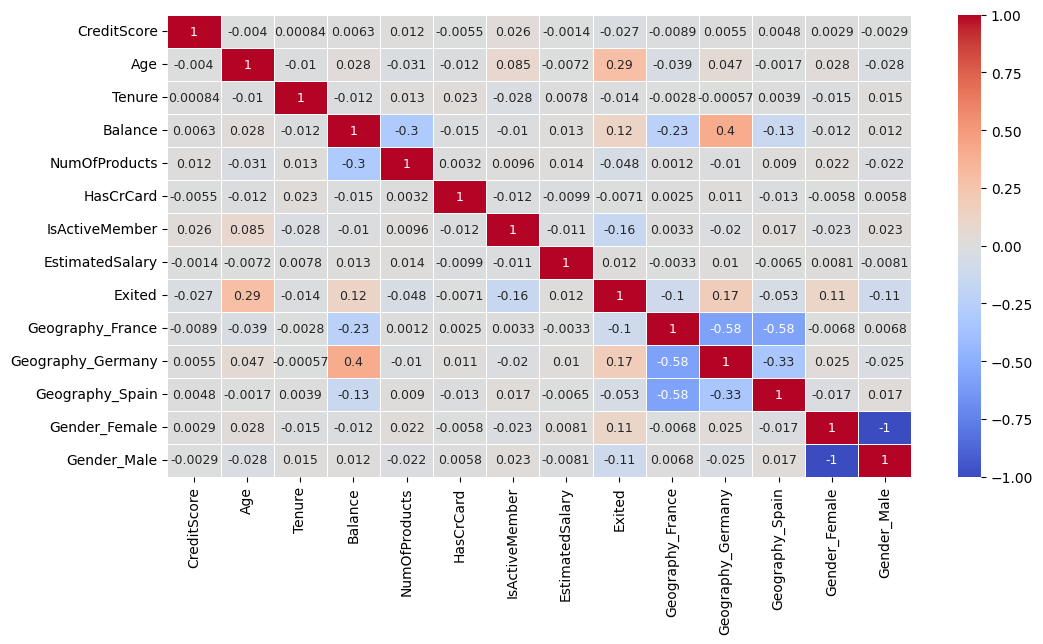

In [38]:
numeric_columns = df.select_dtypes(include='number').columns
corr_matrix = df[numeric_columns].corr()

plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 9})
plt.show()

In [39]:
df.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'Geography_France',
       'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male'],
      dtype='object')

At first glance, the CreditScore, Tenure, NumOfProducts, HasCrCard, EstimatedSalary, and Geography_Spain columns do not exhibit a significant linear dependency on the target column, but we figure out it in the next steps.

# ML section

## Preprocessing

In [42]:
scaler = StandardScaler()
col_to_scale=['CreditScore', 'Age', 'Tenure','Balance', 'NumOfProducts', 'EstimatedSalary']
df[col_to_scale] = scaler.fit_transform(df[col_to_scale])

In [44]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,-0.326221,0.293517,-1.041760,-1.225848,-0.911583,1,1,0.021886,1,1,0,0,1,0
1,-0.440036,0.198164,-1.387538,0.117350,-0.911583,0,1,0.216534,0,0,0,1,1,0
2,-1.536794,0.293517,1.032908,1.333053,2.527057,1,0,0.240687,1,1,0,0,1,0
3,0.501521,0.007457,-1.387538,-1.225848,0.807737,0,0,-0.108918,0,1,0,0,1,0
4,2.063884,0.388871,-1.041760,0.785728,-0.911583,1,1,-0.365276,0,0,0,1,1,0


In [106]:
X_raw = df.drop(columns='Exited')
y_raw = df['Exited']

## Classical ML Modeling

### Raw Modeling


In [121]:
def simple_classification_pipeline(X, y, model='random_forest', class_weights=None, model_return=False):
  # model selection
  if model == 'random_forest':
    model = RandomForestClassifier(random_state=42, class_weight=class_weights)
  elif model == 'logistic_regression':
    model = LogisticRegression(random_state=42, class_weight=class_weights)
  else:
    return None

  # splitting
  X_train, X_test, y_train, y_test = train_test_split(
      X,
      y,
      test_size=0.2,
      random_state=42,
      stratify=y
  )

  # model training
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  print('Confusion Matrix')
  print(confusion_matrix(y_test, y_pred))
  print('\n')
  print('Classification Report')
  print(classification_report(y_test, y_pred))

  if model_return:
    return model

In [122]:
model = simple_classification_pipeline(X_raw, y_raw, model_return=True)

Confusion Matrix
[[1538   55]
 [ 229  178]]


Classification Report
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1593
           1       0.76      0.44      0.56       407

    accuracy                           0.86      2000
   macro avg       0.82      0.70      0.74      2000
weighted avg       0.85      0.86      0.84      2000



We can observe that precision and recall for Class 1 are lower than for the majority class due to this class's minority status.

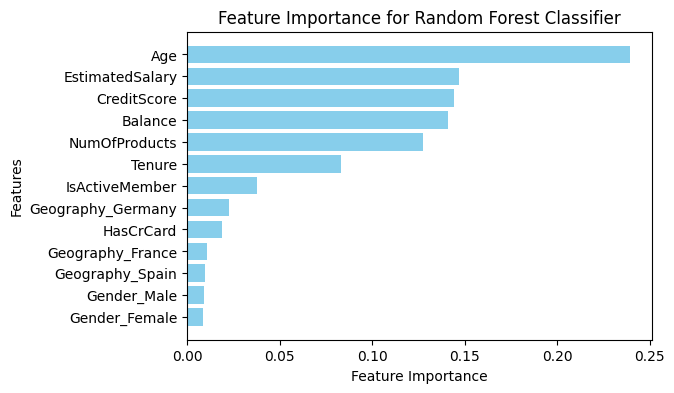

In [123]:
importances = model.feature_importances_
feature_names = X_raw.columns

feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(6, 4))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance for Random Forest Classifier")
plt.gca().invert_yaxis()
plt.show()

### Corrected class weights
Corrected class weights can be implemented in tree-based models, logistic regression, and Artificial Neural Networks (ANNs).

In [128]:
# here, I compute weights based on all classes,
# but we could also consider only the training set's classes

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_raw),
    y=y_raw
)
class_weight_dict = dict(zip(np.unique(y_raw), np.round(class_weights, 2)))

In [129]:
class_weight_dict

{np.int64(0): np.float64(0.63), np.int64(1): np.float64(2.45)}

In [142]:
simple_classification_pipeline(X_raw, y_raw, class_weights=class_weight_dict)

Confusion Matrix
[[1543   50]
 [ 230  177]]


Classification Report
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1593
           1       0.78      0.43      0.56       407

    accuracy                           0.86      2000
   macro avg       0.83      0.70      0.74      2000
weighted avg       0.85      0.86      0.84      2000



### Undersampling
You can randomly reduce data from the majority class until a desired ratio is reached. Under-sampling methods, such as those or NearMiss available in the imblearn package, can also be utilized.

In [143]:
count_class_0, count_class_1 = df['Exited'].value_counts()

# Divide by class
df_class_0 = df[df['Exited'] == 0]
df_class_1 = df[df['Exited'] == 1]

In [147]:
# as we generate random sample from majority class
np.random.seed(42)

df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under['Exited'].value_counts())

Random under-sampling:
Exited
0    2037
1    2037
Name: count, dtype: int64


In [148]:
X = df_test_under.drop(columns='Exited')
y = df_test_under['Exited']

In [149]:
simple_classification_pipeline(X, y)

Confusion Matrix
[[326  82]
 [ 96 311]]


Classification Report
              precision    recall  f1-score   support

           0       0.77      0.80      0.79       408
           1       0.79      0.76      0.78       407

    accuracy                           0.78       815
   macro avg       0.78      0.78      0.78       815
weighted avg       0.78      0.78      0.78       815



It's evident that this method enhances the F1-score for Class 1, while slightly reducing the f1-score for Class 0.

### Oversampling (with SMOTE)
This approach is prone to overfitting, a direct consequence of simply duplicating minority training data to achieve class balance. Over-Sampling methods, such as those available in the imblearn package. Consequently, I will use the SMOTE method instead; ADASYN is also a viable alternative.

In [154]:
np.random.seed(42)

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X_raw, y_raw)

y_sm.value_counts()

,count
Exited,
1,7963
0,7963


In [155]:
simple_classification_pipeline(X_sm, y_sm)

Confusion Matrix
[[1423  170]
 [ 164 1429]]


Classification Report
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1593
           1       0.89      0.90      0.90      1593

    accuracy                           0.90      3186
   macro avg       0.90      0.90      0.90      3186
weighted avg       0.90      0.90      0.90      3186



### Tomek Links
This method may help make the decision boundary more clear and the model learn the boundary better. Also exist combination of SMOTE AND Tomek like SMOTETomek.

In [156]:
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_raw, y_raw)

In [157]:
simple_classification_pipeline(X_res, y_res)

Confusion Matrix
[[1432   62]
 [ 190  218]]


Classification Report
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1494
           1       0.78      0.53      0.63       408

    accuracy                           0.87      1902
   macro avg       0.83      0.75      0.78      1902
weighted avg       0.86      0.87      0.86      1902



### Ensemble method with undersampling
In this method, we implement N models based on the ratio of data classes, and then use the most frequent answer for classification. If you're working with classical ML algorithms, you can use BalancedBaggingClassifier; for ANNs, this process might need to be implemented manually.

In [162]:
X_train, X_test, y_train, y_test = train_test_split(
    X_raw,
    y_raw,
    test_size=0.2,
    random_state=42,
    stratify=y_raw
)

In [186]:
model = BalancedRandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)
proba = model.predict_proba(X_test)

In [187]:
print('Confusion Matrix')
print(confusion_matrix(y_test, pred))
print('\n')
print('Classification Report')
print(classification_report(y_test, pred))

Confusion Matrix
[[1386  207]
 [ 128  279]]


Classification Report
              precision    recall  f1-score   support

           0       0.92      0.87      0.89      1593
           1       0.57      0.69      0.62       407

    accuracy                           0.83      2000
   macro avg       0.74      0.78      0.76      2000
weighted avg       0.85      0.83      0.84      2000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


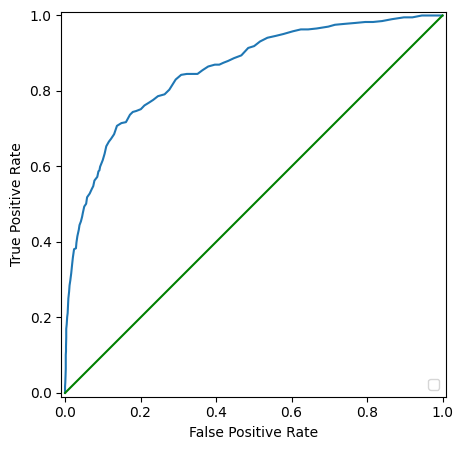

In [188]:
def plot_auc_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')

plot_auc_roc_curve(y_test, proba[:, 1])

In [182]:
# display = PrecisionRecallDisplay.from_estimator(
#     model, X_test, y_test, name="Average precision")
# _ = display.ax_.set_title("Balanced Classifier")

## ANN Modeling
For ANN modeling, I will use an oversampling method with SMOTE.

In [189]:
X_raw.shape

(10000, 13)

In [195]:
X_train.shape[1]

13

In [201]:
from gc import callbacks
def ANN(model_name, X_train, y_train, X_valid, y_valid, loss):
    model = keras.Sequential([
        keras.layers.Dense(13, input_dim=X_train.shape[1], activation='relu'),
        keras.layers.Dense(10, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    history = model.fit(
        X_train,
        y_train,
        epochs=75,
        validation_data=(X_valid, y_valid),
        callbacks=[early_stop]
    )

    model.save(f"{model_name}.h5")

    y_preds = model.predict(X_valid)  # predict_classes
    y_preds = np.round(y_preds)

    print("Classification Report: \n", classification_report(y_valid, y_preds))

    print(history)
    return y_preds, history

In [192]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sm,
    y_sm,
    test_size=0.2,
    random_state=42,
    stratify=y_sm
)

In [202]:
y_preds, history = ANN('tf_model_smote', X_train, y_train, X_test, y_test, 'binary_crossentropy')

Epoch 1/75


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6141 - loss: 0.6548 - val_accuracy: 0.7643 - val_loss: 0.5017
Epoch 2/75
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7678 - loss: 0.4910 - val_accuracy: 0.7819 - val_loss: 0.4486
Epoch 3/75
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7867 - loss: 0.4510 - val_accuracy: 0.7910 - val_loss: 0.4340
Epoch 4/75
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7924 - loss: 0.4374 - val_accuracy: 0.7976 - val_loss: 0.4278
Epoch 5/75
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7978 - loss: 0.4327 - val_accuracy: 0.8057 - val_loss: 0.4188
Epoch 6/75
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8043 - loss: 0.4193 - val_accuracy: 0.8092 - val_loss: 0.4138
Epoch 7/75
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7998 - loss: 0.4192 - val_accuracy: 0.8092 - val_loss: 0.4120
Epoch 8/75
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8011 - loss: 0.4173 - val_accuracy: 0.8120 - val_

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.85      0.83      1593
           1       0.85      0.80      0.82      1593

    accuracy                           0.83      3186
   macro avg       0.83      0.83      0.83      3186
weighted avg       0.83      0.83      0.83      3186



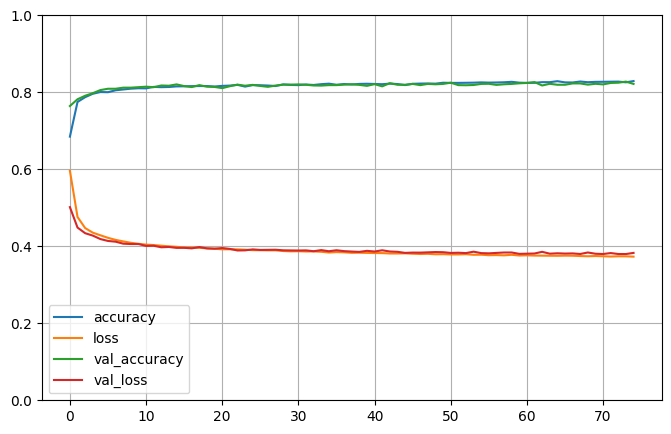

In [203]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()